In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import space, gp_minimize
from functools import partial
import math
import matplotlib.pyplot as plt

In [9]:
train = pd.read_csv('../data/regression/Real estate train.csv')
train.drop('Unnamed: 0', inplace=True, axis=1)

In [10]:
class LinearReg:
    def fit(self, X, y):
        X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        prod_1 = np.matmul(X.transpose(), X)
        prod_2 = np.matmul(np.linalg.inv(prod_1), X.transpose())
        self.beta = np.matmul(prod_2, y)
    
    def predict(self, X_test):
        tmp = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)
        return np.matmul(tmp, self.beta)

In [11]:
class RidgeReg(float):
    def __init__(self, l):
        self.l = l

    def fit(self, X, y):
        identity_matrix = np.identity(X.shape[1])
        prod_1 = np.matmul(X.transpose(), X)
        prod_2 = self.l * identity_matrix
        term_1 = np.add(prod_1, prod_2)
        prod_3 = np.matmul(np.linalg.inv(term_1), X.transpose())

        center_function = lambda x: x - x.mean()
        y_centered = center_function(y)
        self.y_mean = y.mean()

        self.beta_rdige = np.matmul(prod_3, y_centered)
    
    def predict(self, X_test):
        inverse_center = lambda x: x + self.y_mean
        return inverse_center(np.matmul(X_test, self.beta_rdige))

In [12]:
X_train = train.drop('target', axis=1)
y_train = train['target']

test = pd.read_csv('../data/regression/Real estate test.csv')
test.drop('Unnamed: 0', inplace=True, axis=1)
X_test = test.drop('target', axis=1)
y_test = test['target']


In [13]:
sk_linreg = LinearRegression()
sk_linreg.fit(X_train, y_train)
y_pred = sk_linreg.predict(X_test)


linreg = LinearReg()
linreg.fit(X_train.values, y_train.values)
y_pred_manual = linreg.predict(X_test.values)

print("Sklearn's Linear Regression: ")
print("R2: ", r2_score(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))
print("---------------------")
print("Manual Implementation of Linear Regression: ")
print("R2: ", r2_score(y_test, y_pred_manual))
print("MAE: ", mean_absolute_error(y_test, y_pred_manual))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred_manual)))

Sklearn's Linear Regression: 
R2:  0.6974280661583799
MAE:  4.432079085527506
RMSE:  5.8912026998572085
---------------------
Manual Implementation of Linear Regression: 
R2:  0.6974280661583802
MAE:  4.432079085527504
RMSE:  5.891202699857207


In [14]:
sk_ridge = Ridge(alpha=1)
sk_ridge.fit(X_train.values, y_train.values)
y_pred_ridge = sk_ridge.predict(X_test.values)


ridge_manual = RidgeReg(l = 1)
ridge_manual.fit(X_train.values, y_train.values)
y_pred_ridge_manual = ridge_manual.predict(X_test.values)

print("Sklearn's Ridge: ")
print("R2: ", r2_score(y_test, y_pred_ridge))
print("MAE: ", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("---------------------")
print("Manual Implementation of Ridge Regression: ")
print("R2: ", r2_score(y_test, y_pred_ridge_manual))
print("MAE: ", mean_absolute_error(y_test, y_pred_ridge_manual))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred_ridge_manual)))

Sklearn's Ridge: 
R2:  0.6974584605943197
MAE:  4.436143767402351
RMSE:  5.890906796205769
---------------------
Manual Implementation of Ridge Regression: 
R2:  0.6974584605943213
MAE:  4.436143767402327
RMSE:  5.890906796205754


In [15]:
def optimize(par, x, y):
    model = RidgeReg(l=par)
    kf = KFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]

        xtest = x[test_idx]
        ytest = y[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        fold_acc = r2_score(ytest, preds)
        accuracies.append(fold_acc)
    
    return -1.0 * np.mean(accuracies)

In [16]:
max=0
best_param=0
mean_fold_accs = []
for i in range(0,20):
    res = optimize(par=i, x=X_train.values, y=y_train.values)
    mean_fold_accs.append(-res)
    if (max > res):
        max=res
        best_param=i

print("Best hyperparameter: ", best_param)
print("Highest R2 Score on the folds: ", -max)

Best hyperparameter:  11
Highest R2 Score on the folds:  0.6469289355500194


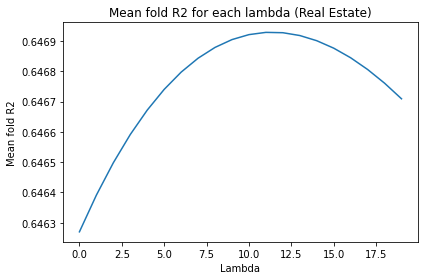

In [17]:
x_vals = list(range(0,20))

plt.plot(x_vals, mean_fold_accs)
plt.title("Mean fold R2 for each lambda (Real Estate)")
plt.xlabel("Lambda")
plt.ylabel("Mean fold R2")
plt.tight_layout()
plt.savefig('Mean fold R2 for each lambda (Real Estate).jpg', dpi=300, bbox_inches='tight')